In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import dLux as dl
from matplotlib import colors, pyplot as plt
import jax.numpy as np
from jax import jit, vmap
import jax.random as jr

import webbpsf
from astropy.io import fits
import astropy.units as u
from tqdm.notebook import tqdm

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [2]:
from dLux import LayeredOptics

Step 1: Make fake data with the same parameters as real data.

In [31]:
# Define the parameters
wf_npixels = 1024
diameter = 6 # metres
psf_npixels = 56
psf_pixel_scale = 0.063 * np.pi / (180*3600)

layers = [
    #(dl.ApertureFactory(wf_npixels), 'aperture'),
    dl.MFT(psf_npixels, psf_pixel_scale),
]

# Construct the optics class
optics = dl.LayeredOptics(wf_npixels, diameter, layers)

wavelengths = np.array([2.82792251e-06])
psf = optics.propagate(wavelengths)

data = psf

(56, 56)


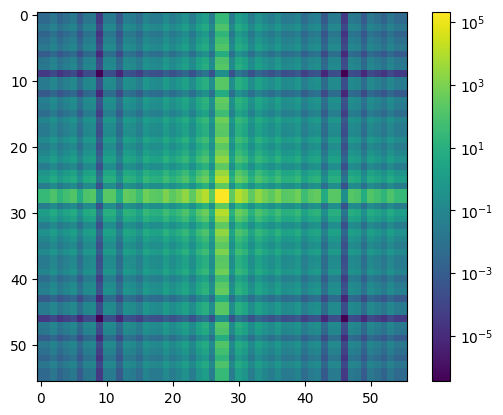

In [32]:
plt.imshow(data, norm="log")
plt.colorbar()
print(data.shape)